In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('Waste Categories Data.xlsx - Raw Data.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    573 non-null    object 
 1   PET (kg)                573 non-null    float64
 2   Hard Plastics (kg)      573 non-null    float64
 3   Flexible Plastics (kg)  573 non-null    object 
 4   Metals & Cans (kg)      573 non-null    float64
 5   Paper (kg)              573 non-null    object 
 6   Glass (kg)              573 non-null    object 
 7   Organics (kg)           573 non-null    object 
dtypes: float64(3), object(5)
memory usage: 35.9+ KB


In [16]:
# 1. Convert date column and sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

In [17]:
# 2. Create time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.strftime('%b')
df['Year_Month'] = df['Date'].dt.to_period('M')

In [22]:
waste_cols = ['PET (kg)', 'Hard Plastics (kg)', 'Flexible Plastics (kg)', 
              'Metals & Cans (kg)', 'Paper (kg)', 'Glass (kg)', 'Organics (kg)']

# Convert all waste columns to numeric, forcing errors to NaN
for col in waste_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for any non-numeric values that were converted to NaN
print("Checking for problematic values...")
for col in waste_cols:
    null_count = df[col].isnull().sum()
    if null_count > 0:
        print(f"{col}: {null_count} non-numeric values found")

# Fill any NaN values with 0 (assuming missing data means no waste collected)
df[waste_cols] = df[waste_cols].fillna(0)

# Now calculate total daily waste
df['Total_Daily'] = df[waste_cols].sum(axis=1)

# Verify it worked
print(df[waste_cols].dtypes)
print(df['Total_Daily'].describe())
df[['Date'] + waste_cols + ['Total_Daily']].head()

Checking for problematic values...
Flexible Plastics (kg): 3 non-numeric values found
Paper (kg): 83 non-numeric values found
Glass (kg): 11 non-numeric values found
Organics (kg): 72 non-numeric values found

✓ Data conversion successful!

Data types after conversion:
PET (kg)                  float64
Hard Plastics (kg)        float64
Flexible Plastics (kg)    float64
Metals & Cans (kg)        float64
Paper (kg)                float64
Glass (kg)                float64
Organics (kg)             float64
dtype: object

Total waste statistics:
count     573.000000
mean     1141.551483
std       966.518740
min         0.000000
25%       311.600000
50%       905.450000
75%      1991.350000
max      3499.320000
Name: Total_Daily, dtype: float64

First few rows with totals:


,Date,PET (kg),Hard Plastics (kg),Flexible Plastics (kg),Metals & Cans (kg),Paper (kg),Glass (kg),Organics (kg),Total_Daily
0,2024-03-07,58.5,49.3,111.3,43.2,249.5,15.1,0.0,526.9
1,2024-03-08,17.9,31.7,29.8,4.1,83.4,0.0,0.0,166.9
2,2024-03-09,23.9,30.7,54.8,7.4,44.8,0.0,0.0,161.6
3,2024-03-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-03-11,39.0,25.0,140.6,18.9,442.6,0.0,0.0,666.1


In [23]:
# 5. Calculate total daily waste
df['Total_Daily'] = df[waste_categories].sum(axis=1)

In [24]:
# Filter out days with zero waste (non-collection days)
df_active = df[df['Total_Daily'] > 0].copy()

print(f"Total days in dataset: {len(df)}")
print(f"Active collection days: {len(df_active)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nTotal waste collected: {df_active['Total_Daily'].sum():,.2f} kg")
print(f"Average daily waste: {df_active['Total_Daily'].mean():,.2f} kg")

# Create monthly aggregation
df_monthly = df_active.groupby('Year_Month')[waste_cols].sum().reset_index()
df_monthly['Total'] = df_monthly[waste_cols].sum(axis=1)
df_monthly['Date'] = df_monthly['Year_Month'].dt.to_timestamp()

print(f"\nMonthly summary created: {len(df_monthly)} months of data")
df_monthly.head()

Total days in dataset: 573
Active collection days: 452
Date range: 2024-03-07 00:00:00 to 2025-09-30 00:00:00

Total waste collected: 654,109.00 kg
Average daily waste: 1,447.14 kg

Monthly summary created: 19 months of data


,Year_Month,PET (kg),Hard Plastics (kg),Flexible Plastics (kg),Metals & Cans (kg),Paper (kg),Glass (kg),Organics (kg),Total,Date
0,2024-03,724.40,520.80,1337.10,610.1,2805.40,537.40,337.00,6872.20,2024-03-01
1,2024-04,1354.00,617.25,2528.00,793.0,5145.40,668.38,1573.94,12679.97,2024-04-01
2,2024-05,1531.93,816.00,3143.85,1204.6,5828.47,780.45,1215.38,14520.68,2024-05-01
3,2024-06,1076.60,525.25,2011.02,1046.0,4007.10,529.68,1334.95,10530.60,2024-06-01
4,2024-07,1502.75,703.05,2778.50,1211.8,5141.10,681.48,1442.42,13461.10,2024-07-01


In [25]:
# Calculate total waste by category
total_by_category = df_active[waste_cols].sum().sort_values(ascending=False)
percentages = (total_by_category / total_by_category.sum() * 100).round(2)

print("WASTE COMPOSITION ANALYSIS")
print("="*50)
for cat, total in total_by_category.items():
    pct = percentages[cat]
    cat_name = cat.replace(' (kg)', '')
    print(f"{cat_name:25s}: {total:10,.2f} kg ({pct:5.2f}%)")

WASTE COMPOSITION ANALYSIS
Flexible Plastics        : 183,489.25 kg (28.05%)
Paper                    : 171,438.44 kg (26.21%)
Organics                 : 103,385.13 kg (15.81%)
Glass                    :  66,717.70 kg (10.20%)
PET                      :  64,799.16 kg ( 9.91%)
Metals & Cans            :  35,837.64 kg ( 5.48%)
Hard Plastics            :  28,441.68 kg ( 4.35%)


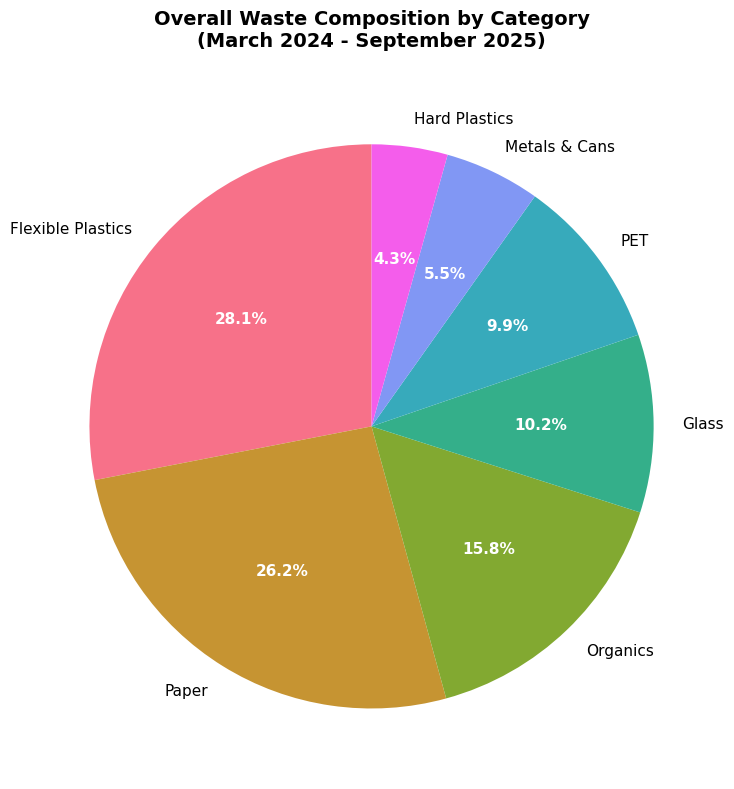


✓ Chart 1 Complete: Overall composition shows Flexible Plastics is the dominant category at 28.1%


In [27]:
# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))

# Clean category names for display
labels = [col.replace(' (kg)', '') for col in total_by_category.index]
colors = sns.color_palette("husl", len(labels))

wedges, texts, autotexts = ax.pie(total_by_category.values, 
                                    labels=labels,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors,
                                    textprops={'fontsize': 11})

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.set_title('Overall Waste Composition by Category\n(March 2024 - September 2025)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n✓ Chart 1 Complete: Overall composition shows {labels[0]} is the dominant category at {percentages.iloc[0]:.1f}%")

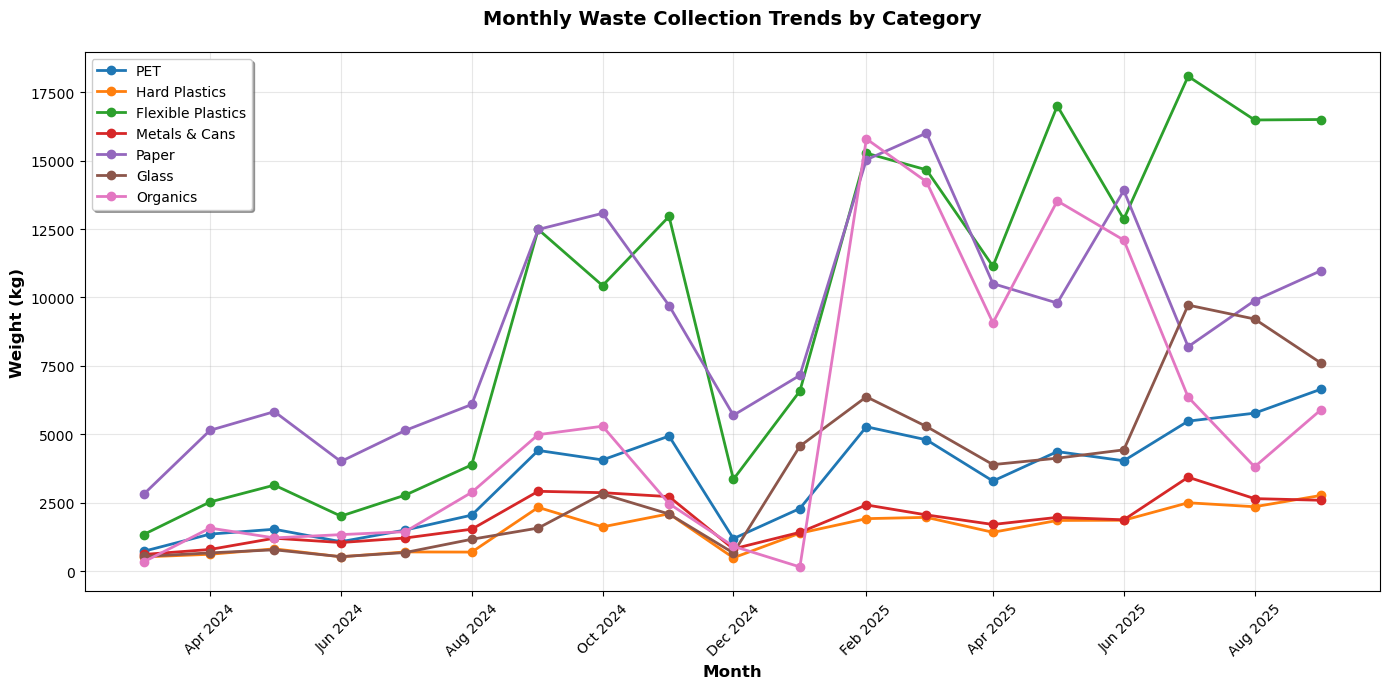


✓ Chart 2 Complete: Monthly trends showing all categories over time


In [28]:
# Monthly trends line chart
fig, ax = plt.subplots(figsize=(14, 7))

for col in waste_cols:
    cat_name = col.replace(' (kg)', '')
    ax.plot(df_monthly['Date'], df_monthly[col], marker='o', label=cat_name, linewidth=2)

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Weight (kg)', fontsize=12, fontweight='bold')
ax.set_title('Monthly Waste Collection Trends by Category', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

# Format x-axis to show dates nicely
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Chart 2 Complete: Monthly trends showing all categories over time")

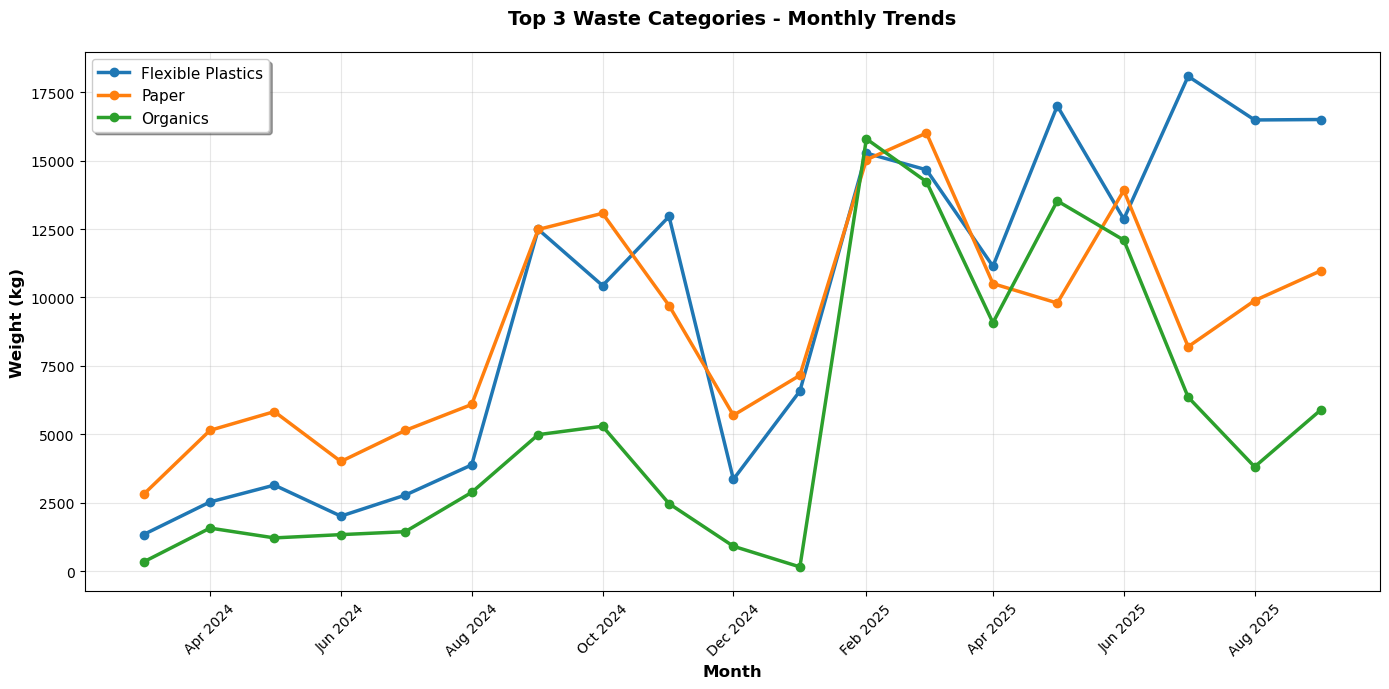


✓ Chart 3 Complete: Focused view on top 3 categories


In [29]:
# Focus on top 3 categories for clearer visualization
top_3_categories = total_by_category.head(3).index.tolist()

fig, ax = plt.subplots(figsize=(14, 7))

for col in top_3_categories:
    cat_name = col.replace(' (kg)', '')
    ax.plot(df_monthly['Date'], df_monthly[col], marker='o', label=cat_name, linewidth=2.5, markersize=6)

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Weight (kg)', fontsize=12, fontweight='bold')
ax.set_title('Top 3 Waste Categories - Monthly Trends', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=True, shadow=True, fontsize=11)
ax.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Chart 3 Complete: Focused view on top 3 categories")

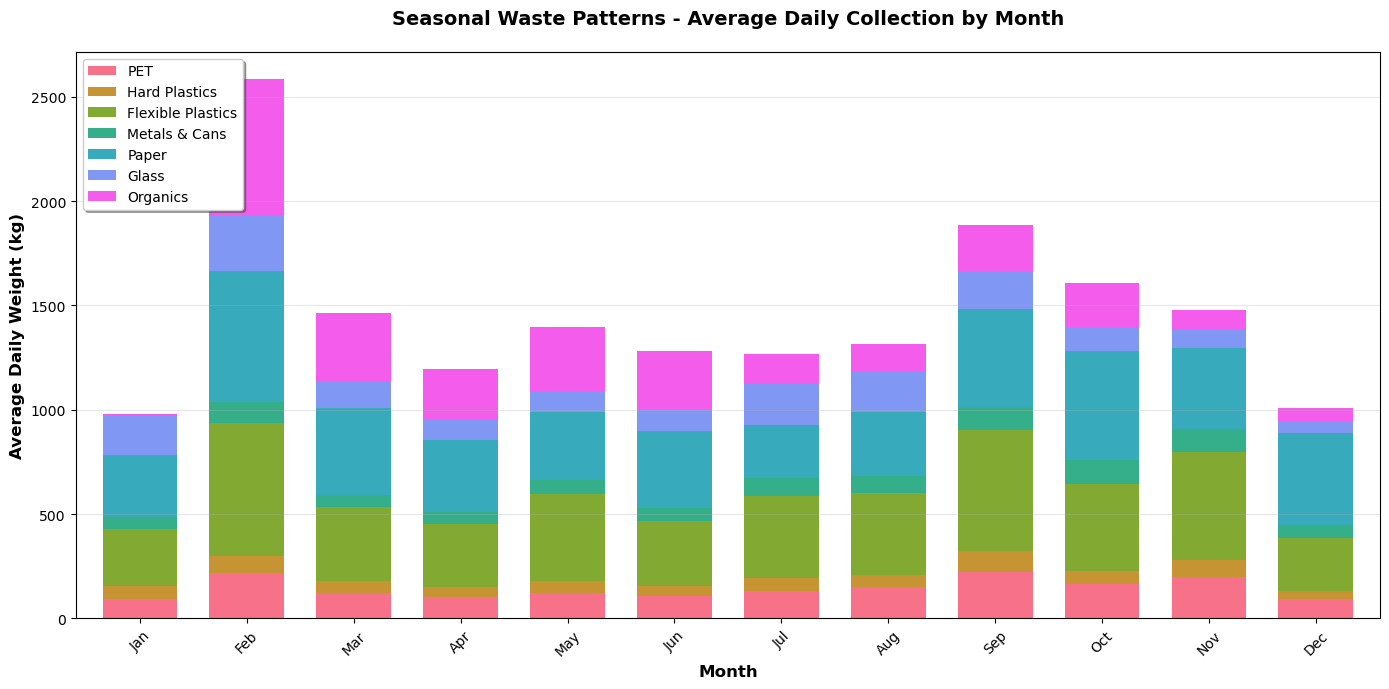


✓ Chart 4 Complete: Seasonal patterns showing which months have highest waste


In [30]:
# Calculate average waste by month (across all years)
df_active['Month_Num'] = df_active['Month']
monthly_avg = df_active.groupby('Month_Num')[waste_cols].mean()

# Create month names for x-axis
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg.index = [month_names[i-1] for i in monthly_avg.index]

# Stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

# Clean category names
clean_cols = [col.replace(' (kg)', '') for col in waste_cols]

monthly_avg.plot(kind='bar', stacked=True, ax=ax, width=0.7, 
                 color=sns.color_palette("husl", len(waste_cols)))

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Daily Weight (kg)', fontsize=12, fontweight='bold')
ax.set_title('Seasonal Waste Patterns - Average Daily Collection by Month', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(clean_cols, loc='upper left', frameon=True, shadow=True)
ax.set_xticklabels(monthly_avg.index, rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Chart 4 Complete: Seasonal patterns showing which months have highest waste")

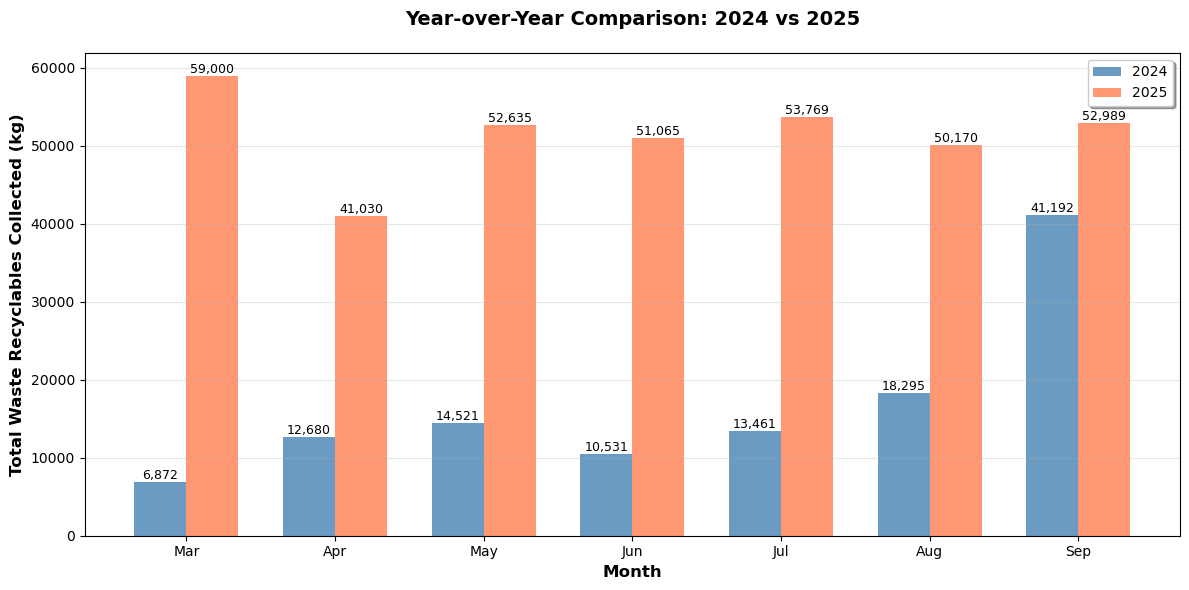


✓ Chart 5 Complete: Year-over-year comparison
2024 Total (comparable months): 207,818.20 kg
2025 Total (comparable months): 446,290.80 kg
Growth: +114.8%


In [32]:
# Compare 2024 vs 2025 for overlapping months (Mar-Oct)
df_2024 = df_active[df_active['Year'] == 2024].copy()
df_2025 = df_active[df_active['Year'] == 2025].copy()

# Monthly totals for each year
monthly_2024 = df_2024.groupby('Month')[waste_cols].sum().sum(axis=1)
monthly_2025 = df_2025.groupby('Month')[waste_cols].sum().sum(axis=1)

# Find common months
common_months = sorted(set(monthly_2024.index) & set(monthly_2025.index))

if len(common_months) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(common_months))
    width = 0.35
    
    month_labels = [month_names[m-1] for m in common_months]
    
    bars1 = ax.bar(x - width/2, [monthly_2024.get(m, 0) for m in common_months], 
                   width, label='2024', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, [monthly_2025.get(m, 0) for m in common_months], 
                   width, label='2025', color='coral', alpha=0.8)
    
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Waste Recyclables Collected (kg)', fontsize=12, fontweight='bold')
    ax.set_title('Year-over-Year Comparison: 2024 vs 2025', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels)
    ax.legend(frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:,.0f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate growth
    total_2024 = monthly_2024.sum()
    total_2025 = monthly_2025.sum()
    growth_pct = ((total_2025 - total_2024) / total_2024 * 100) if total_2024 > 0 else 0
    
    print(f"\n✓ Chart 5 Complete: Year-over-year comparison")
    print(f"2024 Total (comparable months): {total_2024:,.2f} kg")
    print(f"2025 Total (comparable months): {total_2025:,.2f} kg")
    print(f"Growth: {growth_pct:+.1f}%")
else:
    print("Not enough overlapping months for comparison")

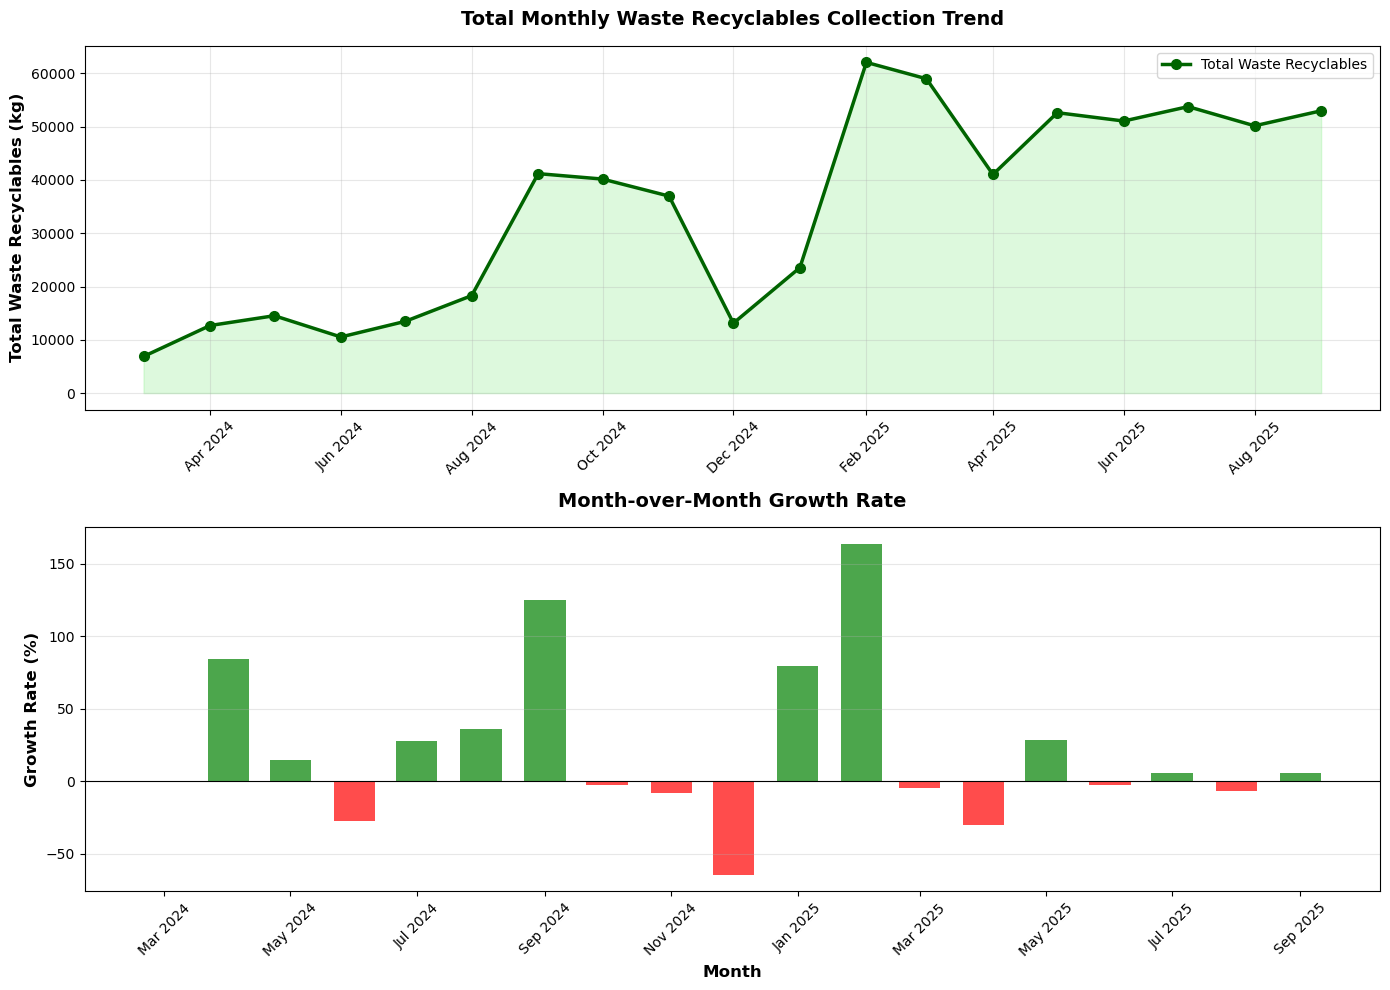


✓ Chart 6 Complete: Growth trend analysis showing overall trajectory and volatility


In [34]:
# Calculate month-over-month growth
df_monthly['Total_Growth'] = df_monthly['Total'].pct_change() * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Total waste over time
ax1.plot(df_monthly['Date'], df_monthly['Total'], marker='o', 
         linewidth=2.5, markersize=7, color='darkgreen', label='Total Waste Recyclables')
ax1.fill_between(df_monthly['Date'], df_monthly['Total'], alpha=0.3, color='lightgreen')
ax1.set_ylabel('Total Waste Recyclables (kg)', fontsize=12, fontweight='bold')
ax1.set_title('Total Monthly Waste Recyclables Collection Trend', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Month-over-month growth rate
colors = ['green' if x > 0 else 'red' for x in df_monthly['Total_Growth'].fillna(0)]
ax2.bar(df_monthly['Date'], df_monthly['Total_Growth'].fillna(0), 
        color=colors, alpha=0.7, width=20)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
ax2.set_ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Month-over-Month Growth Rate', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

# Format dates
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Chart 6 Complete: Growth trend analysis showing overall trajectory and volatility")

In [37]:
# Calculate key business metrics
print("BUSINESS INSIGHTS SUMMARY")
print("="*70)

# 1. Overall Performance
total_waste = df_active['Total_Daily'].sum()
avg_daily = df_active['Total_Daily'].mean()
collection_days = len(df_active)

print("\n1. OVERALL PERFORMANCE")
print(f"   • Total waste processed: {total_waste:,.2f} kg")
print(f"   • Active collection days: {collection_days}")
print(f"   • Average daily collection: {avg_daily:,.2f} kg")
print(f"   • Analysis period: {(df['Date'].max() - df['Date'].min()).days} days ({len(df_monthly)} months)")

# 2. Category Performance
print("\n2. TOP PERFORMING CATEGORIES")
for i, (cat, total) in enumerate(total_by_category.head(3).items(), 1):
    cat_name = cat.replace(' (kg)', '')
    pct = percentages[cat]
    print(f"   #{i}: {cat_name:20s} - {total:10,.2f} kg ({pct:.1f}%)")

# 3. Organics Analysis (Critical for BSF operations)
organics_total = df_active['Organics (kg)'].sum()
organics_avg_daily = df_active['Organics (kg)'].mean()
organics_pct = (organics_total / total_waste * 100)

print(f"\n3. ORGANICS ANALYSIS (BSF Feed)")
print(f"   • Total organics: {organics_total:,.2f} kg ({organics_pct:.1f}% of total waste)")
print(f"   • Average daily organics: {organics_avg_daily:,.2f} kg")
print(f"   • Monthly average: {organics_avg_daily * 30:,.2f} kg")

# Find months with highest/lowest organics
monthly_organics = df_active.groupby('Month_Name')['Organics (kg)'].mean().sort_values(ascending=False)
print(f"   • Best month for organics: {monthly_organics.index[0]} (avg: {monthly_organics.iloc[0]:.2f} kg/day)")
print(f"   • Lowest month: {monthly_organics.index[-1]} (avg: {monthly_organics.iloc[-1]:.2f} kg/day)")

# 4. Growth Metrics
if len(df_2024) > 0 and len(df_2025) > 0:
    total_2024_all = df_2024[waste_cols].sum().sum()
    total_2025_all = df_2025[waste_cols].sum().sum()
    
    # Calculate months in each year
    months_2024 = df_2024['Month'].nunique()
    months_2025 = df_2025['Month'].nunique()
    
    avg_monthly_2024 = total_2024_all / months_2024 if months_2024 > 0 else 0
    avg_monthly_2025 = total_2025_all / months_2025 if months_2025 > 0 else 0
    
    growth = ((avg_monthly_2025 - avg_monthly_2024) / avg_monthly_2024 * 100) if avg_monthly_2024 > 0 else 0
    
    print(f"\n4. YEAR-OVER-YEAR GROWTH")
    print(f"   • 2024 average monthly: {avg_monthly_2024:,.2f} kg ({months_2024} months)")
    print(f"   • 2025 average monthly: {avg_monthly_2025:,.2f} kg ({months_2025} months)")
    print(f"   • Average growth rate: {growth:+.1f}%")

# 5. Operational Insights
best_month = df_monthly.loc[df_monthly['Total'].idxmax()]
worst_month = df_monthly.loc[df_monthly['Total'].idxmin()]

print(f"\n5. OPERATIONAL PATTERNS")
print(f"   • Highest collection month: {best_month['Year_Month']} ({best_month['Total']:,.2f} kg)")
print(f"   • Lowest collection month: {worst_month['Year_Month']} ({worst_month['Total']:,.2f} kg)")

# Variability
std_dev = df_monthly['Total'].std()
cv = (std_dev / df_monthly['Total'].mean() * 100)
print(f"   • Collection variability (CV): {cv:.1f}% ", end="")
if cv < 20:
    print("(Stable operations)")
elif cv < 40:
    print("(Moderate variability)")
else:
    print("(High variability - investigate causes)")

print("\n" + "="*70)

BUSINESS INSIGHTS SUMMARY

1. OVERALL PERFORMANCE
   • Total waste processed: 654,109.00 kg
   • Active collection days: 452
   • Average daily collection: 1,447.14 kg
   • Analysis period: 572 days (19 months)

2. TOP PERFORMING CATEGORIES
   #1: Flexible Plastics    - 183,489.25 kg (28.1%)
   #2: Paper                - 171,438.44 kg (26.2%)
   #3: Organics             - 103,385.13 kg (15.8%)

3. ORGANICS ANALYSIS (BSF Feed)
   • Total organics: 103,385.13 kg (15.8% of total waste)
   • Average daily organics: 228.73 kg
   • Monthly average: 6,861.84 kg
   • Best month for organics: Feb (avg: 658.03 kg/day)
   • Lowest month: Jan (avg: 6.48 kg/day)

4. YEAR-OVER-YEAR GROWTH
   • 2024 average monthly: 20,781.82 kg (10 months)
   • 2025 average monthly: 49,587.87 kg (9 months)
   • Average growth rate: +138.6%

5. OPERATIONAL PATTERNS
   • Highest collection month: 2025-02 (62,078.45 kg)
   • Lowest collection month: 2024-03 (6,872.20 kg)
   • Collection variability (CV): 55.4% (High va

FORECAST: NEXT 3 MONTHS

Method: Linear Trend + Moving Average
Trend: +2813.25 kg per month (R² = 0.689)

Forecasted Total Waste Collection:

   October 2025   :     62,559 kg
   November 2025  :     65,373 kg
   December 2025  :     68,186 kg


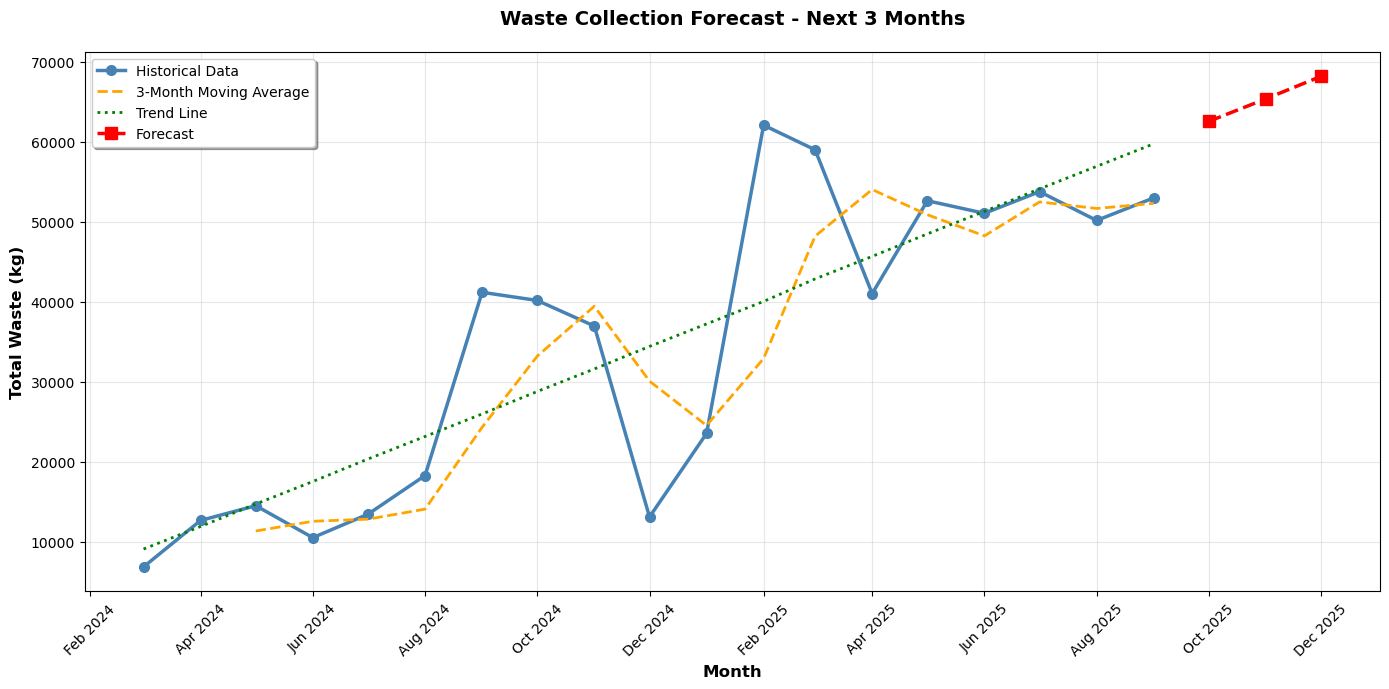


✓ Forecast Complete: Simple linear projection based on historical trend


In [40]:
# Simple forecasting using moving average and trend
print("FORECAST: NEXT 3 MONTHS")
print("="*100)

# Calculate 3-month moving average
df_monthly['MA_3'] = df_monthly['Total'].rolling(window=3).mean()

# Calculate trend (simple linear)
from scipy import stats
x = np.arange(len(df_monthly))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, df_monthly['Total'])

# Forecast next 3 months
forecast_months = 3
future_x = np.arange(len(df_monthly), len(df_monthly) + forecast_months)
forecast_values = slope * future_x + intercept

# Get last date and create future dates
last_date = df_monthly['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

print(f"\nMethod: Linear Trend + Moving Average")
print(f"Trend: {slope:+.2f} kg per month (R² = {r_value**2:.3f})")
print(f"\nForecasted Total Waste Collection:\n")

for date, forecast in zip(future_dates, forecast_values):
    print(f"   {date.strftime('%B %Y'):15s}: {forecast:>10,.0f} kg")

# Visualization of forecast
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data
ax.plot(df_monthly['Date'], df_monthly['Total'], marker='o', 
        linewidth=2.5, markersize=7, color='steelblue', label='Historical Data')

# Moving average
ax.plot(df_monthly['Date'], df_monthly['MA_3'], 
        linewidth=2, color='orange', linestyle='--', label='3-Month Moving Average')

# Trend line
trend_line = slope * x + intercept
ax.plot(df_monthly['Date'], trend_line, 
        linewidth=2, color='green', linestyle=':', label='Trend Line')

# Forecast
ax.plot(future_dates, forecast_values, marker='s', 
        linewidth=2.5, markersize=8, color='red', linestyle='--', label='Forecast')

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Waste (kg)', fontsize=12, fontweight='bold')
ax.set_title('Waste Collection Forecast - Next 3 Months', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Forecast Complete: Simple linear projection based on historical trend")
print("="*100)